In [1]:
!which python

/home/hb/anaconda3/envs/pp_predict/bin/python


In [3]:
!conda list


# packages in environment at /home/hb/anaconda3/envs/pp_predict:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                      1_llvm    conda-forge
absl-py                   1.0.0                    pypi_0    pypi
alsa-lib                  1.2.3                h516909a_0    conda-forge
argon2-cffi               21.3.0             pyhd3eb1b0_0  
argon2-cffi-bindings      21.2.0           py39h7f8727e_0  
astunparse                1.6.3                    pypi_0    pypi
attrs                     21.4.0             pyhd3eb1b0_0  
backcall                  0.2.0              pyhd3eb1b0_0  
blas                      1.0                         mkl  
bleach                    4.1.0              pyhd3eb1b0_0  
brotli                    1.0.9                h7f98852_6    conda-forge
brotli-bin                1.0.9                h7f98852_6    conda-forge
brotlipy 

In [4]:
import sys
sys.path.append('/home/hb/anaconda3/envs/pp_predict/lib/python3.9/site-packages')
sys.path.append('/home/hb/python/pp_pred/Module')

In [5]:

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import torch.utils.data as data_utils
from torch.autograd import Variable
import pickle
from sklearn.model_selection import train_test_split
import math
import os           
import re
from collections import Counter
from functools import partial
from torch import optim
from torchsummary import summary
from efficientnet_model import EfficientNet
from Radam import RAdam
import random
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [6]:
torch.cuda.is_available()

True

In [7]:
allele = 'phospho-B-15'
model = EfficientNet.from_name(f'efficientnet-{allele}')

efficientnet-phospho-B-15


In [8]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    1, 8, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((1, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(8, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        8, 8, kernel_size=(3, 3), stride=[1, 1], groups=8, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(8, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        8, 2, kernel_size=(3, 3), stride=(1, 1)
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_se_expand): Conv2dStaticSamePadding(
        2, 8, kernel_size=(3, 3), stride=(1, 1)
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_project_conv): Conv2dStaticSamePadding(
        8, 16, kernel_size=(3, 3), stride=(1, 1)

In [9]:
def precision_recall(y_true, y_pred):
    '''Calculate F1 score. Can work with gpu tensors
    
    The original implmentation is written by Michal Haltuf on Kaggle.
    
    Returns
    -------
    torch.Tensor
        `ndim` == 1. epsilon <= val <= 1
    
    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    - http://www.ryanzhang.info/python/writing-your-own-loss-function-module-for-pytorch/
    '''
# TP : True positive, 실제로 True인데 분류모델에서 예측이 True라고 판단한 경우 -> 정답을 정답이라 맞췄다 !!!!
# TN : True negative, 실제로 False인데 분류모델에서 예측이 False라고 판단한 경우 -> 오답을 오답이라 맞췄다!!!
# FP : False positive, 실제로 False인데 분류모델에서 예측이 True라고 판단한 경우 -> 아... 오답인데 정답이라 해버렸다
# FN : False negative, 실제 True인데 분류모델에서 예측이 False라고 판단한 경우 -> 아... 정답인데 오답이라 했다


# Precision(정밀도) = tp / (tp + fp)
# Recall(재현율) = tp / (tp + fn)
# Sensitivity(=Recall, 민감도) : 실제 결과가 True인 것 중 True의 비율 = TN / (FP + TN)
# Specificity(특이도) : Sensitivity와 반대되는 개념, False set을 입력했을 때, False로 인식한 것의 비율 = TN / (FP + TN)
# Precision(정확룰) : 정답이라고 예측한 것 중에 실제로 정답인 것의 비율. = 

    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
    
    epsilon = 1e-7
    # epsilon을 사용하는 이유 : 분모가 0이 됨을 방지
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    specificity = tn / (tn + fp + epsilon)
    
    Accurancy = (tp + tn) / (tp + tn + fp + fn + epsilon)
    f1 = 2 * (precision*recall) / (precision + recall + epsilon)

    return precision, recall, f1, Accurancy

In [10]:
def get_tpr(y_true,y_scores,threshold):
    predict_positive_num = len(y_scores[y_scores >= threshold]) 
    tp = len([x for x in y_true[:predict_positive_num] if x == 1])
    ground_truth = len(y_true[y_true==1]) 
    tpr =  tp / ground_truth
    return tpr
    
def get_fpr(y_true,y_scores,threshold):
    predict_positive_num = len(y_scores[y_scores >= threshold] )
    fp = len([x for x in y_true[:predict_positive_num] if x == 0 ])
    ground_negative = len(y_true[y_true==0])
    fpr = fp / ground_negative
    return fpr

 '''
 ROC, AUC, TPR(True Positivie Rate), FPR(False Positive Rate) 설명 : https://angeloyeo.github.io/2020/08/05/ROC.html
 '''   

### 전역변수와 지역변수
프로그래밍 언어에서 변수를 분류하는 방법은 여러가지가 있다. 그 중에 하나로 전역변수와 지역변수의 개념이 있다.  
일반적으로 전역변수는 프로그램에 혼란을 주기 때문에 사용을 권장하지 않는다.  
하지만, 코딩을 하다보면 전역변수를 사용하면 더 쉽게 코딩할 수 있는 경우가 있다.  
그 외에도 유용하게 사용할 수 있는 방법이 있다. 오늘은 파이썬 global 전역변수 사용방법과 사용예에 대해서 알아보도록 하겠다.

- 지역변수 : a나 b는 test()함수 밖에서는 사용할 수 없다. 이를 지역변수라고 한다
```
def test():
    a = 3
    b = 2
 
    return a + b
```
- 전역변수를 선언하는 방법 : 함수 안에서 global로 전역변수 선언하기, global을 앞에 붙인 a는 함수 밖에서도 사용을 할 수 있다.
```
def test():
    global a
    a = 3
    b = 2
 
    return a + b
```

In [11]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, f1_score
from tqdm import tqdm_notebook
from tqdm.notebook import tnrange, tqdm
import time
import scikitplot as skplt



def train_model(model, optimizer, scheduler, num_epochs):
    global best_acc
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    since = time.time()

# state_dict : 각 계층을 매개변수 텐서로 매핑되는 Python 사전(dict) 객체
    best_model_wts = model.state_dict() 
    best_loss = 1000.0
    best_acc = 0

'''모델과 데이터 병렬의 구현    
이것은 이 튜토리얼의 핵심 부분입니다. 먼저, model instance 를 만들고 가지고 있는 GPU가 여러개인지 확인해야합니다. 
만약 다수의 GPU를 보유중이라면, nn.DataParallel 을 사용하여 모델을 래핑 (wrapping) 할 수 있습니다. 그런 다음 model.to(device) 를 통하여 모델을 GPU에 넣을 수 있습니다.    
    --------
    model = Model(input_size, output_size)
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        model = nn.DataParallel(model)

    model.to(device)
    ---------

    Reference : https://tutorials.pytorch.kr/beginner/blitz/data_parallel_tutorial.html 
    '''
    
    if torch.cuda.device_count() > 1:
        print("Training on ", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model) # DataParallel을 이용하여 모델을 병렬로 실행하는 다수의 GPU에서 쉽게 작업을 실행할 수 있습니다.

    model.to(device) 


    #criterion.to(device)
    # https://gooopy.tistory.com/68
    for epoch in tqdm(range(num_epochs)):
        print('-' * 60)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        
        # training step
        global Trainfprs, Traintprs, Trainthresholds, TrainTruedata, TrainScoredata, TrainLossdata
        optimizer.step()
        scheduler.step()
        model.train(True)
        training_loss = 0.0
        training_corrects = 0.0
        training_precision, training_recall, training_f1 = 0.0, 0.0, 0.0
        TrainTruedata, TrainScoredata, TrainLossdata  = [],[],[]
        Trainfprs, Traintprs, Trainthresholds = 0.0, 0.0, 0.0
        

        for data in tqdm(dataloaders['train']):
             # get the inputs
            inputs, labels = data
#            inputs = Variable(inputs.to(device, dtype=torch.float))
#            labels = Variable(labels.to(device))
            inputs = inputs.to(device, dtype=torch.float32).clone().detach()
            labels = labels.to(device).clone().detach()
        
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            preds = (outputs>=0.5).float()
            precision, recall, f1 = precision_recall(labels.float().view(-1,1).cpu(), preds.cpu())
            loss = criterion(outputs, labels.float().view(-1,1)).to(device)

            #train_output += list(outputs.cpu().detach().numpy())
            #backward + optimize only if in training phase
            
            loss.backward()
            optimizer.step()

            # statistics
            training_loss += loss.data
            training_precision += precision.data
            training_recall += recall.data
            training_f1 += f1.data
            
            

            training_corrects += accuracy_score(labels.cpu(), preds.cpu())
            TrainTruedata.extend(labels.cpu().numpy())
            TrainScoredata.extend(outputs.detach().cpu().numpy())

        #Trainfprs, Traintprs, Trainthresholds = roc_curve(TrainTruedata, TrainScoredata)
        Trainfprs, Traintprs, Trainthresholds = roc_curve(TrainTruedata, TrainScoredata) 
        #[0]는 batchsize28353일때 batchsize줄이면 extend()활용필요
        Train_auc_score = roc_auc_score(TrainTruedata, TrainScoredata)
        
        

        
        epoch_train_loss = training_loss / dataset_sizes['train']
        epoch_train_precision = training_precision / dataset_sizes['train']
        epoch_train_recall = training_recall / dataset_sizes['train']
        epoch_train_f1 = training_f1 / dataset_sizes['train']
        epoch_train_acc = training_corrects / dataset_sizes['train']
        TrainLossdata.append(epoch_train_loss)

        
        print('{} Loss: {:.4f} Acc: {:.4f} Recall: {:.4f} AUC: {:.4f}'.format(
            'train', epoch_train_loss, epoch_train_acc, epoch_train_recall, Train_auc_score))

        
        # Validation step
        global Validfprs, Validtprs, Validthresholds,ValidTruedata, ValidScoredata, ValidLossdata
        model.train(False)
        val_loss = 0.0
        val_corrects = 0.0
        val_precision, val_recall, val_f1 = 0.0, 0.0, 0.0
        ValidTruedata, ValidScoredata ,ValidLossdata = [],[],[]
        Validfprs, Validtprs, Validthresholds = 0.0, 0.0, 0.0

        
        for data in tqdm(dataloaders['valid']):
             # get the inputs
            inputs, labels = data
            #inputs = Variable(inputs.to(device, dtype=torch.float))
            #labels = Variable(labels.to(device))
            inputs = inputs.to(device, dtype=torch.float32).clone().detach()
            labels = labels.to(device).clone().detach()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            preds = (outputs>=0.5).float()
            #_, preds = torch.max(outputs.data, 1)
            #loss = F.binary_cross_entropy(outputs, labels.float().view(-1,1)).to(device)
            #loss = F1_Loss(labels.float().view(-1,1).cpu(), outputs.cpu())
            precision, recall, f1 = precision_recall(labels.float().view(-1,1).cpu(), preds.cpu())
            loss = criterion(outputs, labels.float().view(-1,1)).to(device)

            

            # statistics
            val_loss += loss.data
            val_precision += precision.data
            val_recall += recall.data
            val_f1 += f1.data
            

            val_corrects += accuracy_score(labels.cpu(), preds.cpu())
            #valreport = classification_report(labels.cpu(), preds.cpu())
            ValidTruedata.extend(labels.cpu().numpy())
            ValidScoredata.extend(outputs.detach().cpu().numpy())

        Validfprs, Validtprs, Validthresholds = roc_curve(ValidTruedata, ValidScoredata)
        Valid_auc_score = roc_auc_score(ValidTruedata, ValidScoredata)
        
            
        
        epoch_val_loss = val_loss / dataset_sizes['valid']
        epoch_val_precision = val_precision / dataset_sizes['valid']
        epoch_val_recall = val_recall / dataset_sizes['valid']
        epoch_val_f1 = val_f1 / dataset_sizes['valid']
        epoch_val_acc = val_corrects / dataset_sizes['valid']


        writer.add_scalars('Loss' , {'train':epoch_train_loss, 'validation':epoch_val_loss}, epoch)
        writer.add_scalars('Accuracy' , {'train':epoch_train_acc, 'validation':epoch_val_acc},  epoch)
        writer.add_scalars('F1' , {'train':epoch_train_f1, 'validation':epoch_val_f1},  epoch)
        writer.add_scalars('precision' , {'train':epoch_train_precision, 'validation':epoch_val_precision},  epoch)
        writer.add_scalars('recall' , {'train':epoch_train_recall, 'validation':epoch_val_recall},  epoch)


        print('{} Loss: {:.4f} Acc: {:.4f} recall: {:.4f} AUC: {:.4f}'.format(
            'validation', epoch_val_loss, epoch_val_acc ,epoch_val_recall, Valid_auc_score ))

        # deep copy the model
        if  epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            best_model_wts = model.state_dict()
            # save
            checkpoint = {'model': model,
                      #'state_dict': model.module.state_dict(),
                          'state_dict': model.state_dict(),
                      'optimizer' : optimizer.state_dict()}

            savePath = "{}/best_{}.pth".format(save_dir, epoch+1)
            torch.save(checkpoint, savePath)
        else:
            # save
            checkpoint = {'model': model,
                      #'state_dict': model.module.state_dict(),
                          'state_dict': model.state_dict(),
                      'optimizer' : optimizer.state_dict()}

            savePath = "{}/{}.pth".format(save_dir, epoch+1)
            torch.save(checkpoint, savePath)


        print('-' * 60)
        print()         
        #cf
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
        

    time_elapsed = time.time() - since

    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))
    print('Best val Acc: {:2f}'.format(best_acc))


    
    # load best model weights
    model.load_state_dict(best_model_wts)
    

    

    return model

In [28]:
#아래는 dfspsphmm_ratiorandom data로
with open( "/home/hb/python/pp_prediction/data/(kw)dfpsphmm_ratiorandomver2.pickle", "rb" ) as file:
    df6 = pickle.load(file)

In [29]:
import pandas as pd
df7 = pd.DataFrame(df6,columns=['GENE','KINASE','KIN_ACC_ID','KIN_ORGANISM','SUBSTRATE',
                                'SUB_GENE_ID','SUB_ACC_ID','SUB_GENE','SUB_ORGANISM','SUB_MOD_RSD','SITE_GRP_ID',
                                'SITE_+/-7_AA','DOMAIN','IN_VIVO_RXN','IN_VITRO_RXN','CST_CAT#','KINseq',
                                'Length','answer','singleSITE','matrix'])

In [39]:


df8 = df7.loc[(df7['KIN_ORGANISM'] == 'human') & (df7['SUB_ORGANISM'] == 'human')]
df8




,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,...,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#,KINseq,Length,answer,singleSITE,matrix
7,PRKCD,PKCD,Q05655,human,HDAC5,10014.0,Q9UQL6,HDAC5,human,S259,...,FPLRKTASEPNLKVR,NaN,,X,3443,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,1,"[F, P, L, R, K, T, A, S, E, P, N, L, K, V, R]","[[[1.061, 0.825, 1.012, 0.963, 0.6885, 1.026, ..."
8,PRKCD,PKCD,Q05655,human,PTPRA iso2,5786.0,P18433-2,PTPRA,human,S204,...,PLLARSPSTNRKYPP,NaN,X,,NaN,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,1,"[P, L, L, A, R, S, P, S, T, N, R, K, Y, P, P]","[[[0.825, 1.012, 1.012, 1.032, 0.963, 0.9688, ..."
9,PRKCD,PKCD,Q05655,human,Bcl-2,596.0,P10415,BCL2,human,S70,...,RDPVARTSPLQTPAA,NaN,X,,2834; 2827,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,1,"[R, D, P, V, A, R, T, S, P, L, Q, T, P, A, A]","[[[0.963, 0.9204, 0.825, 1.01, 1.032, 0.963, 1..."
10,PRKCD,PKCD,Q05655,human,hnRNP K,3190.0,P61978,HNRNPK,human,S302,...,GRGGRGGSRARNLPL,NaN,X,X,NaN,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,1,"[G, R, G, G, R, G, G, S, R, A, R, N, L, P, L]","[[[1.006, 0.963, 1.006, 1.006, 0.963, 1.006, 1..."
11,PRKCD,PKCD,Q05655,human,SHOC2,8036.0,Q9UQ13,SHOC2,human,T71,...,VAFSVDNTIKRPNPA,NaN,,X,NaN,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,1,"[V, A, F, S, V, D, N, T, I, K, R, P, N, P, A]","[[[1.01, 1.032, 1.061, 0.9688, 1.01, 0.9204, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35437,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,...,STKTGTSTKTKTATF,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,0,"[Q, R, V, L, D, T, S, S, L, T, Q, S, A, P, A]","[[[1.023, 1.027, 1.013, 1.027, 0.981, 1.027, 1..."
35438,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,...,AYIYRYMYSYPYSYD,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,0,"[D, T, S, S, L, T, Q, S, A, P, A, S, P, T, N]","[[[1.124, 1.269, 1.1875, 1.269, 1.062, 1.269, ..."
35439,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,...,GYSYHYGYKYTYLYK,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,0,"[L, A, Q, P, I, N, F, S, V, S, L, S, N, S, H]","[[[0.981, 1.269, 1.023, 1.269, 1.063, 1.269, 0..."
35440,ULK2,ULK2,Q8IYT8,human,PIK3C3,5289.0,Q8NEB9,PIK3C3,human,S249,...,QSTSQSASDSMSKST,NaN,X,,13857,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,0,"[E, S, S, P, I, L, T, S, F, E, L, V, K, V, P]","[[[1.003, 1.023, 1.027, 1.023, 1.003, 1.023, 1..."


In [42]:
df8_answer1 = df8.loc[df8['answer'] == 1]
df8_answer0 = df8.loc[df8['answer'] == 0]
display(df8_answer1)
display(df8_answer0)
                      

,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,...,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#,KINseq,Length,answer,singleSITE,matrix
7,PRKCD,PKCD,Q05655,human,HDAC5,10014.0,Q9UQL6,HDAC5,human,S259,...,FPLRKTASEPNLKVR,NaN,,X,3443,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,1,"[F, P, L, R, K, T, A, S, E, P, N, L, K, V, R]","[[[1.061, 0.825, 1.012, 0.963, 0.6885, 1.026, ..."
8,PRKCD,PKCD,Q05655,human,PTPRA iso2,5786.0,P18433-2,PTPRA,human,S204,...,PLLARSPSTNRKYPP,NaN,X,,NaN,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,1,"[P, L, L, A, R, S, P, S, T, N, R, K, Y, P, P]","[[[0.825, 1.012, 1.012, 1.032, 0.963, 0.9688, ..."
9,PRKCD,PKCD,Q05655,human,Bcl-2,596.0,P10415,BCL2,human,S70,...,RDPVARTSPLQTPAA,NaN,X,,2834; 2827,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,1,"[R, D, P, V, A, R, T, S, P, L, Q, T, P, A, A]","[[[0.963, 0.9204, 0.825, 1.01, 1.032, 0.963, 1..."
10,PRKCD,PKCD,Q05655,human,hnRNP K,3190.0,P61978,HNRNPK,human,S302,...,GRGGRGGSRARNLPL,NaN,X,X,NaN,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,1,"[G, R, G, G, R, G, G, S, R, A, R, N, L, P, L]","[[[1.006, 0.963, 1.006, 1.006, 0.963, 1.006, 1..."
11,PRKCD,PKCD,Q05655,human,SHOC2,8036.0,Q9UQ13,SHOC2,human,T71,...,VAFSVDNTIKRPNPA,NaN,,X,NaN,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,1,"[V, A, F, S, V, D, N, T, I, K, R, P, N, P, A]","[[[1.01, 1.032, 1.061, 0.9688, 1.01, 0.9204, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17716,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,...,QRVLDTSSLTQSAPA,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1,"[Q, R, V, L, D, T, S, S, L, T, Q, S, A, P, A]","[[[1.003, 1.062, 1.165, 1.152, 0.8477, 1.027, ..."
17717,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,...,DTSSLTQSAPASPTN,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1,"[D, T, S, S, L, T, Q, S, A, P, A, S, P, T, N]","[[[0.8477, 1.027, 1.023, 1.023, 1.152, 1.027, ..."
17718,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,...,LAQPINFSVSLSNSH,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1,"[L, A, Q, P, I, N, F, S, V, S, L, S, N, S, H]","[[[1.152, 1.124, 1.003, 0.886, 1.1875, 1.003, ..."
17719,ULK2,ULK2,Q8IYT8,human,PIK3C3,5289.0,Q8NEB9,PIK3C3,human,S249,...,ESSPILTSFELVKVP,NaN,X,,13857,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1,"[E, S, S, P, I, L, T, S, F, E, L, V, K, V, P]","[[[0.865, 1.023, 1.023, 0.886, 1.1875, 1.152, ..."


,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,...,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#,KINseq,Length,answer,singleSITE,matrix
17728,PRKCD,PKCD,Q05655,human,HDAC5,10014.0,Q9UQL6,HDAC5,human,S259,...,PTRTQTPTSTKTATA,NaN,,X,3443,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,0,"[F, P, L, R, K, T, A, S, E, P, N, L, K, V, R]","[[[0.825, 1.026, 0.963, 1.026, 0.886, 1.026, 0..."
17729,PRKCD,PKCD,Q05655,human,PTPRA iso2,5786.0,P18433-2,PTPRA,human,S204,...,SSPSVSDSHSRSGSE,NaN,X,,NaN,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,0,"[P, L, L, A, R, S, P, S, T, N, R, K, Y, P, P]","[[[0.9688, 0.9688, 0.825, 0.9688, 1.01, 0.9688..."
17730,PRKCD,PKCD,Q05655,human,Bcl-2,596.0,P10415,BCL2,human,S70,...,AYAYRYSYSYNYNYA,NaN,X,,2834; 2827,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,0,"[R, D, P, V, A, R, T, S, P, L, Q, T, P, A, A]","[[[1.032, 1.063, 1.032, 1.063, 0.963, 1.063, 0..."
17731,PRKCD,PKCD,Q05655,human,hnRNP K,3190.0,P61978,HNRNPK,human,S302,...,IYLYLYFYIYSYEYR,NaN,X,X,NaN,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,0,"[G, R, G, G, R, G, G, S, R, A, R, N, L, P, L]","[[[1.027, 1.063, 1.012, 1.063, 1.012, 1.063, 1..."
17732,PRKCD,PKCD,Q05655,human,SHOC2,8036.0,Q9UQ13,SHOC2,human,T71,...,RSNSISKSGSNSLSG,NaN,,X,NaN,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,0,"[V, A, F, S, V, D, N, T, I, K, R, P, N, P, A]","[[[0.963, 0.9688, 0.8755, 0.9688, 1.027, 0.968..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35437,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,...,STKTGTSTKTKTATF,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,0,"[Q, R, V, L, D, T, S, S, L, T, Q, S, A, P, A]","[[[1.023, 1.027, 1.013, 1.027, 0.981, 1.027, 1..."
35438,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,...,AYIYRYMYSYPYSYD,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,0,"[D, T, S, S, L, T, Q, S, A, P, A, S, P, T, N]","[[[1.124, 1.269, 1.1875, 1.269, 1.062, 1.269, ..."
35439,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,...,GYSYHYGYKYTYLYK,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,0,"[L, A, Q, P, I, N, F, S, V, S, L, S, N, S, H]","[[[0.981, 1.269, 1.023, 1.269, 1.063, 1.269, 0..."
35440,ULK2,ULK2,Q8IYT8,human,PIK3C3,5289.0,Q8NEB9,PIK3C3,human,S249,...,QSTSQSASDSMSKST,NaN,X,,13857,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,0,"[E, S, S, P, I, L, T, S, F, E, L, V, K, V, P]","[[[1.003, 1.023, 1.027, 1.023, 1.003, 1.023, 1..."


In [43]:
df8_answer1 = df8_answer1.sample(n=5000)
df8_answer0 = df8_answer0.sample(n=5000)

In [45]:
df8 = pd.concat([df8_answer1, df8_answer0], axis=0)
df8

,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,...,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#,KINseq,Length,answer,singleSITE,matrix
767,CSNK2A1,CK2A1,P68400,human,CREB3,10488.0,O43889,CREB3,human,S46,...,LPLSEVPSDWEVDDL,NaN,X,X,NaN,YQLVRKLGRGKYSEVFEAINITNNEKVVVKILKPVKKKKIKREIKI...,285,1,"[L, P, L, S, E, V, P, S, D, W, E, V, D, D, L]","[[[1.152, 0.886, 1.152, 1.023, 0.865, 1.165, 0..."
10453,MAPK1,ERK2,P28482,human,DAPK1,1612.0,P53355,DAPK1,human,S734,...,NSSRFPPSPLASKPT,NaN,X,X,NaN,YTNLSYIGEGAYGMVCSAYDNVNKVRVAIKKISPFEHQTYCQRTLR...,288,1,"[N, S, S, R, F, P, P, S, P, L, A, S, K, P, T]","[[[1.003, 1.023, 1.023, 1.062, 1.211, 0.886, 0..."
2299,MAPKAPK2,MAPKAPK2,P49137,human,TH iso3,7054.0,P07101-3,TH,human,S40,...,RFIGRRQSLIEDARK,TOH_N,,X,2791,SQVLGLGINGKVLQIFNKRTQEKFALKMLQDCPKARREVELHWRAS...,258,1,"[R, F, I, G, R, R, Q, S, L, I, E, D, A, R, K]","[[[0.881, 1.079, 1.025, 1.013, 0.881, 0.881, 0..."
8926,GRK5,GRK5,P34947,human,ADRB2,154.0,P07550,ADRB2,human,S401,...,VPSDNIDSQGRNCST,NaN,,X,NaN,RQYRVLGKGGFGEVCACQVRATGKMYACKRLEKKRIKKRKGESMAL...,261,1,"[V, P, S, D, N, I, D, S, Q, G, R, N, C, S, T]","[[[1.035, 0.7417, 0.881, 1.039, 0.8115, 0.966,..."
14812,PRKCA,PKCA,P17252,human,Kv1.5,3741.0,P22460,KCNA5,human,T15,...,LENGGAMTVRGGDEA,NaN,X,,NaN,FLMVLGKGSFGKVMLADRKGTEELYAIKILKKDVVIQDDDVECTMV...,242,1,"[L, E, N, G, G, A, M, T, V, R, G, G, D, E, A]","[[[1.097, 0.88, 0.962, 1.02, 1.02, 1.115, 1.16..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33992,WEE1,Wee1,P30291,human,CDK2,1017.0,P24941,CDK2,human,Y15,...,AYSYWYAYDYTYPYS,Pkinase,X,X,NaN,FHELEKIGSGEFGSVFKCVKRLDGCIYAIKRSKKPLAGSVDEQNAL...,269,0,"[E, K, I, G, E, G, T, Y, G, V, V, Y, K, A, R]","[[[1.115, 1.211, 1.079, 1.211, 1.163, 1.211, 1..."
30553,CSNK1A1,CK1A,P48729,human,NFAT4,4775.0,Q12968,NFATC3,human,S207,...,QYQYSYQYEYLYKYN,NaN,X,X,NaN,YKLVRKIGSGSFGDIYLAINITNGEEVAVKLESQKARHPQLLYESK...,218,0,"[A, A, R, F, T, L, G, S, P, L, T, S, P, G, G]","[[[1.003, 1.269, 1.003, 1.269, 1.023, 1.269, 1..."
34266,EGFR,EGFR,P00533,human,SOX2,6657.0,P48431,SOX2,human,Y277,...,SYGYIYDYVYGYLYP,NaN,X,,NaN,FKKIKVLGSGAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANK...,252,0,"[L, R, D, M, I, S, M, Y, L, P, G, A, E, V, P]","[[[1.079, 1.211, 1.02, 1.211, 1.135, 1.211, 0...."
28383,MET,Met,P08581,human,GSK3B,2932.0,P49841,GSK3B,human,Y56,...,ESSSASLSMSASQSG,Pkinase,X,X,NaN,HFNEVIGRGHFGCVYHGTLLDNDGKKIHCAVKSLNRITDIGEVSQF...,256,0,"[D, R, P, Q, E, V, S, Y, T, D, T, K, V, I, G]","[[[0.793, 0.9688, 0.9688, 0.9688, 1.032, 0.968..."


In [15]:
# # df7_j = df7.iloc[::2,:] #짝수행
# # df7_h = df7.iloc[1::2,:] #홀수행


# df7_j['answer'] = 1
# df7_j

# df7_h['answer'] = 0
# df7_h 

# df8 = pd.concat([df7_j, df7_h], axis=0)
# df8

# df7 = df8

In [46]:
df7 = df8

In [47]:
dfr2 = []
dfl2 = []
for i in df7['matrix']:
    dfr2.append(i)
for i in df7['answer']:
    dfl2.append(i)
dfr2 ,dfl2= np.array(dfr2),np.array(dfl2)
dfl2 = dfl2.reshape(10000,1)
print(dfr2.shape)
dfl2.shape

(10000, 1, 336, 15)


(10000, 1)

In [48]:
kf2 = KFold(n_splits = 5, random_state = 42, shuffle = True) 
data_indexgen2 = kf2.split(dfr2)

In [49]:
data_index2 = []
for i in data_indexgen2:
    data_index2.append(i)

In [50]:
dfr_temp2 = []
dfl_temp2 = []
for tr_idx, val_idx in kf2.split(dfr2):
    dfr_temp2.append(tr_idx)
    dfl_temp2.append(val_idx)

In [51]:
len(dfr_temp2[0])

8000

In [52]:
len(dfl_temp2[0])

2000

In [53]:
criterion = nn.BCELoss()
optimizer = RAdam(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)#step_size,gamma는 lr에 영향을 미치므로 확인

In [54]:
#Writer will output to ./runs/ directory by default
save_dir = f'saved_model_samp10000/Efficientnet_0_kernel_3_ms_only_same_ratio'
writer = SummaryWriter(save_dir)

In [ ]:
#batch_size=1인경우

best_acc_sum = 0
for fold, (tr_idx, val_idx) in enumerate(kf2.split(dfr2)):
    
    print('Fold: {:d}'.format(fold))
    BATCH_SIZE = 1

    train_set = data_utils.TensorDataset(torch.tensor(dfr2[tr_idx]), torch.tensor(dfl2[tr_idx]))
    valid_set = data_utils.TensorDataset(torch.tensor(dfr2[val_idx]),torch.tensor(dfl2[val_idx]))

    train_loader = data_utils.DataLoader(train_set, batch_size=BATCH_SIZE, pin_memory=False, shuffle=True)
    valid_loader = data_utils.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)


    dataloaders = {'train':train_loader,'valid':valid_loader}
    dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'valid']}
    
    model = train_model(model, optimizer, scheduler, 20)
    
    plt.figure(figsize=[10,10],dpi = 300)
    plt.plot([0,1],[0,1])
    plt.plot(Trainfprs, Traintprs, label= 'Train')
    plt.plot(Validfprs, Validtprs, label= 'Valid')
    plt.legend()
    plt.xlim()
    plt.ylim(0,1)
    plt.xlabel("1-specificity", fontsize =10)
    plt.ylabel("sensitivity", fontsize =10)
    plt.show()
    best_acc_sum += best_acc
    del model
    allele = 'phospho-B-15'
    model = EfficientNet.from_name(f'efficientnet-{allele}')
    criterion = nn.BCELoss()
    optimizer = RAdam(model.parameters())
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    
    save_dir = f'saved_modeltemp/Efficientnet_{fold+1}_kernel_3_ms_only_same_ratio'
    writer = SummaryWriter(save_dir)
    
    if fold == 4:
        print('Kfold_cv_mean: {:2f}'.format(best_acc_sum/(fold+1)))

In [58]:
#batch_size=32인경우
save_dir = f'saved_model_samp10000_samp32/Efficientnet_0_kernel_3_ms_only_same_ratio'
writer = SummaryWriter(save_dir)

Fold: 0
Training on  4 GPUs!


  0%|          | 0/20 [00:00<?, ?it/s]

------------------------------------------------------------
Epoch 1/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.3514 Acc: 0.8850 Recall: 0.8637 AUC: 0.9511


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.3326 Acc: 0.9157 recall: 0.9053 AUC: 0.9597
------------------------------------------------------------

------------------------------------------------------------
Epoch 2/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.3238 Acc: 0.9010 Recall: 0.8823 AUC: 0.9601


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.3056 Acc: 0.9152 recall: 0.8826 AUC: 0.9668
------------------------------------------------------------

------------------------------------------------------------
Epoch 3/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.2953 Acc: 0.9141 Recall: 0.9009 AUC: 0.9674


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.2739 Acc: 0.9350 recall: 0.9236 AUC: 0.9723
------------------------------------------------------------

------------------------------------------------------------
Epoch 4/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.2679 Acc: 0.9217 Recall: 0.9059 AUC: 0.9735


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.2462 Acc: 0.9400 recall: 0.9326 AUC: 0.9774
------------------------------------------------------------

------------------------------------------------------------
Epoch 5/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.2429 Acc: 0.9303 Recall: 0.9189 AUC: 0.9781


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.2258 Acc: 0.9430 recall: 0.9273 AUC: 0.9821
------------------------------------------------------------

------------------------------------------------------------
Epoch 6/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.2192 Acc: 0.9413 Recall: 0.9342 AUC: 0.9829


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.1980 Acc: 0.9529 recall: 0.9499 AUC: 0.9853
------------------------------------------------------------

------------------------------------------------------------
Epoch 7/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.2012 Acc: 0.9467 Recall: 0.9390 AUC: 0.9851


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.1787 Acc: 0.9539 recall: 0.9404 AUC: 0.9879
------------------------------------------------------------

------------------------------------------------------------
Epoch 8/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.1809 Acc: 0.9525 Recall: 0.9462 AUC: 0.9885


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.1604 Acc: 0.9618 recall: 0.9524 AUC: 0.9900
------------------------------------------------------------

------------------------------------------------------------
Epoch 9/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.1690 Acc: 0.9557 Recall: 0.9481 AUC: 0.9898


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.1451 Acc: 0.9707 recall: 0.9694 AUC: 0.9918
------------------------------------------------------------

------------------------------------------------------------
Epoch 10/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.1565 Acc: 0.9556 Recall: 0.9494 AUC: 0.9912


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.1317 Acc: 0.9692 recall: 0.9571 AUC: 0.9932
------------------------------------------------------------

------------------------------------------------------------
Epoch 11/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.1399 Acc: 0.9646 Recall: 0.9611 AUC: 0.9929


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.1198 Acc: 0.9707 recall: 0.9546 AUC: 0.9945
------------------------------------------------------------

------------------------------------------------------------
Epoch 12/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.1303 Acc: 0.9664 Recall: 0.9607 AUC: 0.9942


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.1076 Acc: 0.9737 recall: 0.9635 AUC: 0.9953
------------------------------------------------------------

------------------------------------------------------------
Epoch 13/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.1196 Acc: 0.9708 Recall: 0.9688 AUC: 0.9952


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0996 Acc: 0.9777 recall: 0.9684 AUC: 0.9961
------------------------------------------------------------

------------------------------------------------------------
Epoch 14/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.1086 Acc: 0.9725 Recall: 0.9649 AUC: 0.9960


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0928 Acc: 0.9797 recall: 0.9740 AUC: 0.9967
------------------------------------------------------------

------------------------------------------------------------
Epoch 15/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.1027 Acc: 0.9766 Recall: 0.9707 AUC: 0.9961


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0841 Acc: 0.9807 recall: 0.9745 AUC: 0.9974
------------------------------------------------------------

------------------------------------------------------------
Epoch 16/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.0927 Acc: 0.9772 Recall: 0.9712 AUC: 0.9974


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0782 Acc: 0.9816 recall: 0.9731 AUC: 0.9978
------------------------------------------------------------

------------------------------------------------------------
Epoch 17/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.0898 Acc: 0.9790 Recall: 0.9738 AUC: 0.9971


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0707 Acc: 0.9836 recall: 0.9784 AUC: 0.9982
------------------------------------------------------------

------------------------------------------------------------
Epoch 18/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.0797 Acc: 0.9806 Recall: 0.9742 AUC: 0.9976


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0663 Acc: 0.9841 recall: 0.9788 AUC: 0.9985
------------------------------------------------------------

------------------------------------------------------------
Epoch 19/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.0765 Acc: 0.9809 Recall: 0.9757 AUC: 0.9981


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0639 Acc: 0.9831 recall: 0.9782 AUC: 0.9988
------------------------------------------------------------

------------------------------------------------------------
Epoch 20/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.0714 Acc: 0.9839 Recall: 0.9777 AUC: 0.9982


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0567 Acc: 0.9846 recall: 0.9791 AUC: 0.9990
------------------------------------------------------------

Training complete in 1m 4s
Best val Loss: 0.056709
Best val Acc: 0.984623


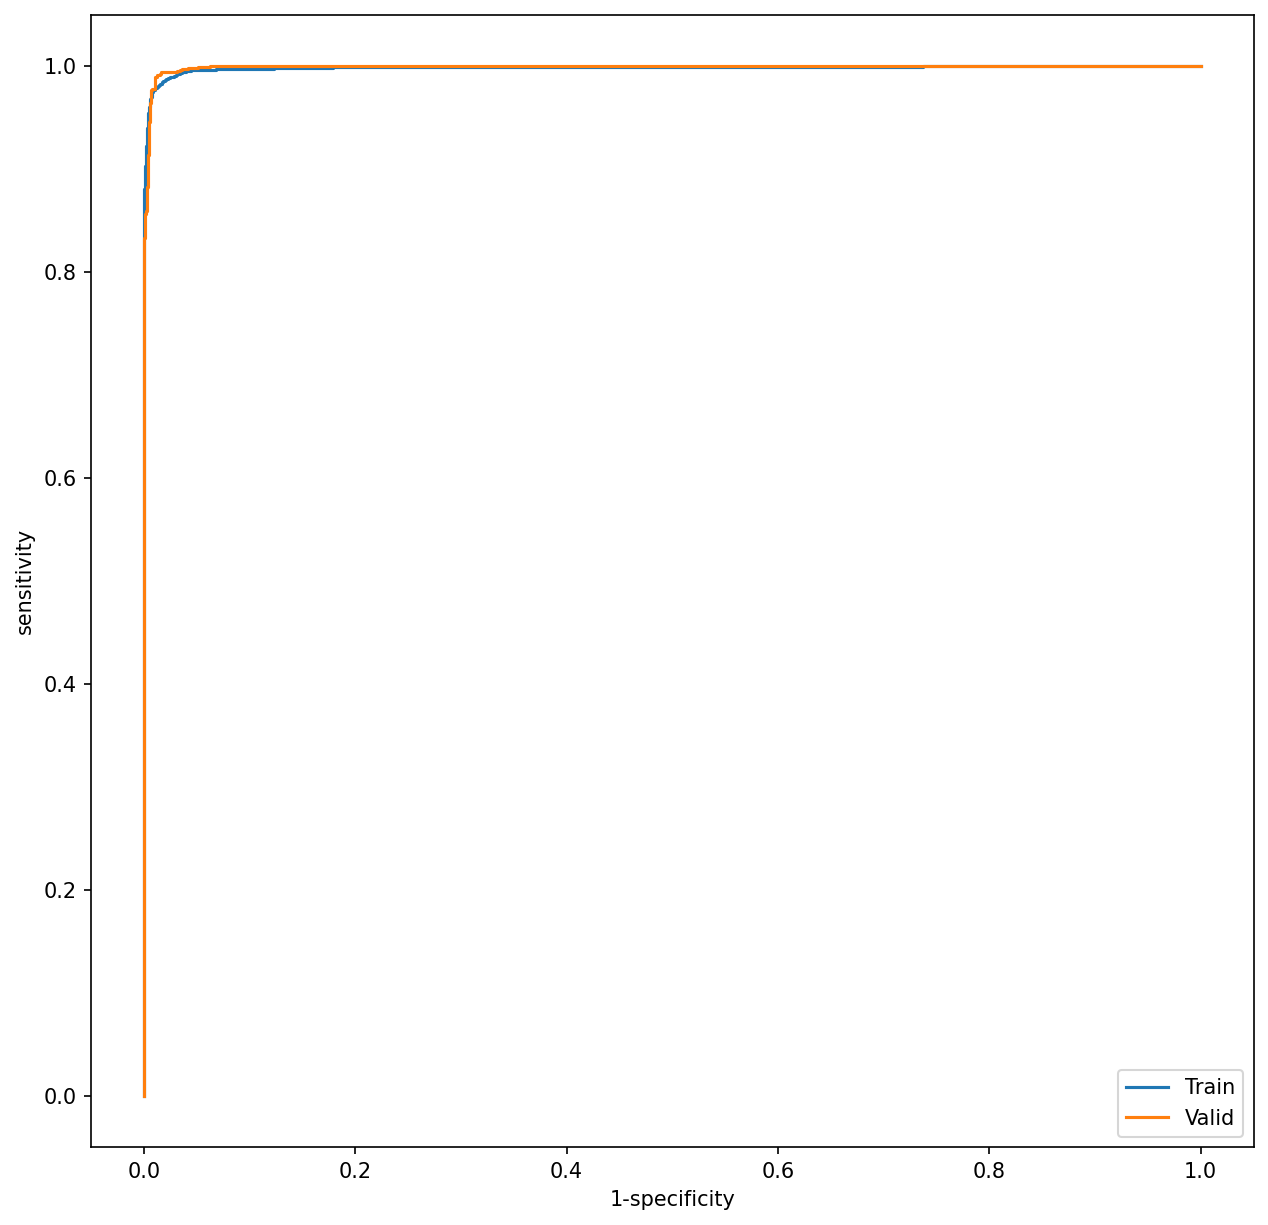

efficientnet-phospho-B-15
Fold: 1
Training on  4 GPUs!


  0%|          | 0/20 [00:00<?, ?it/s]

------------------------------------------------------------
Epoch 1/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.6902 Acc: 0.5470 Recall: 0.3587 AUC: 0.5583


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.6925 Acc: 0.5407 recall: 0.2206 AUC: 0.5511
------------------------------------------------------------

------------------------------------------------------------
Epoch 2/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.6635 Acc: 0.6122 Recall: 0.5365 AUC: 0.6500


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.6644 Acc: 0.6344 recall: 0.5153 AUC: 0.6981
------------------------------------------------------------

------------------------------------------------------------
Epoch 3/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.6316 Acc: 0.6760 Recall: 0.6062 AUC: 0.7378


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.6239 Acc: 0.6855 recall: 0.5164 AUC: 0.7927
------------------------------------------------------------

------------------------------------------------------------
Epoch 4/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.5906 Acc: 0.7324 Recall: 0.6570 AUC: 0.8098


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.5751 Acc: 0.7604 recall: 0.6779 AUC: 0.8508
------------------------------------------------------------

------------------------------------------------------------
Epoch 5/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.5454 Acc: 0.7754 Recall: 0.7212 AUC: 0.8546


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.5293 Acc: 0.8016 recall: 0.7585 AUC: 0.8822
------------------------------------------------------------

------------------------------------------------------------
Epoch 6/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.4976 Acc: 0.8011 Recall: 0.7468 AUC: 0.8844


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.4845 Acc: 0.8170 recall: 0.7728 AUC: 0.8994
------------------------------------------------------------

------------------------------------------------------------
Epoch 7/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.4575 Acc: 0.8206 Recall: 0.7783 AUC: 0.8995


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.4476 Acc: 0.8219 recall: 0.7452 AUC: 0.9110
------------------------------------------------------------

------------------------------------------------------------
Epoch 8/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.4239 Acc: 0.8327 Recall: 0.8001 AUC: 0.9101


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.4193 Acc: 0.8423 recall: 0.7887 AUC: 0.9208
------------------------------------------------------------

------------------------------------------------------------
Epoch 9/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.3971 Acc: 0.8411 Recall: 0.8122 AUC: 0.9190


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.3941 Acc: 0.8467 recall: 0.7792 AUC: 0.9285
------------------------------------------------------------

------------------------------------------------------------
Epoch 10/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.3767 Acc: 0.8481 Recall: 0.8174 AUC: 0.9246


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.3740 Acc: 0.8502 recall: 0.7838 AUC: 0.9367
------------------------------------------------------------

------------------------------------------------------------
Epoch 11/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.3487 Acc: 0.8610 Recall: 0.8357 AUC: 0.9368


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.3513 Acc: 0.8641 recall: 0.8057 AUC: 0.9433
------------------------------------------------------------

------------------------------------------------------------
Epoch 12/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.3313 Acc: 0.8722 Recall: 0.8488 AUC: 0.9428


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.3257 Acc: 0.8805 recall: 0.8414 AUC: 0.9500
------------------------------------------------------------

------------------------------------------------------------
Epoch 13/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.3120 Acc: 0.8794 Recall: 0.8581 AUC: 0.9499


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.3095 Acc: 0.8839 recall: 0.8353 AUC: 0.9553
------------------------------------------------------------

------------------------------------------------------------
Epoch 14/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.2974 Acc: 0.8808 Recall: 0.8610 AUC: 0.9541


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.2963 Acc: 0.8894 recall: 0.8401 AUC: 0.9606
------------------------------------------------------------

------------------------------------------------------------
Epoch 15/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.2819 Acc: 0.8906 Recall: 0.8713 AUC: 0.9597


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.2735 Acc: 0.9127 recall: 0.8943 AUC: 0.9652
------------------------------------------------------------

------------------------------------------------------------
Epoch 16/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.2599 Acc: 0.9044 Recall: 0.8953 AUC: 0.9667


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.2625 Acc: 0.9023 recall: 0.8538 AUC: 0.9697
------------------------------------------------------------

------------------------------------------------------------
Epoch 17/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.2549 Acc: 0.9083 Recall: 0.8940 AUC: 0.9668


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.2432 Acc: 0.9142 recall: 0.8768 AUC: 0.9734
------------------------------------------------------------

------------------------------------------------------------
Epoch 18/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.2409 Acc: 0.9097 Recall: 0.8916 AUC: 0.9714


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.2277 Acc: 0.9306 recall: 0.9209 AUC: 0.9766
------------------------------------------------------------

------------------------------------------------------------
Epoch 19/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.2243 Acc: 0.9199 Recall: 0.9023 AUC: 0.9752


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.2151 Acc: 0.9276 recall: 0.8967 AUC: 0.9794
------------------------------------------------------------

------------------------------------------------------------
Epoch 20/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.2132 Acc: 0.9240 Recall: 0.9111 AUC: 0.9777


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.2068 Acc: 0.9246 recall: 0.8897 AUC: 0.9819
------------------------------------------------------------

Training complete in 1m 8s
Best val Loss: 0.206815
Best val Acc: 0.930556


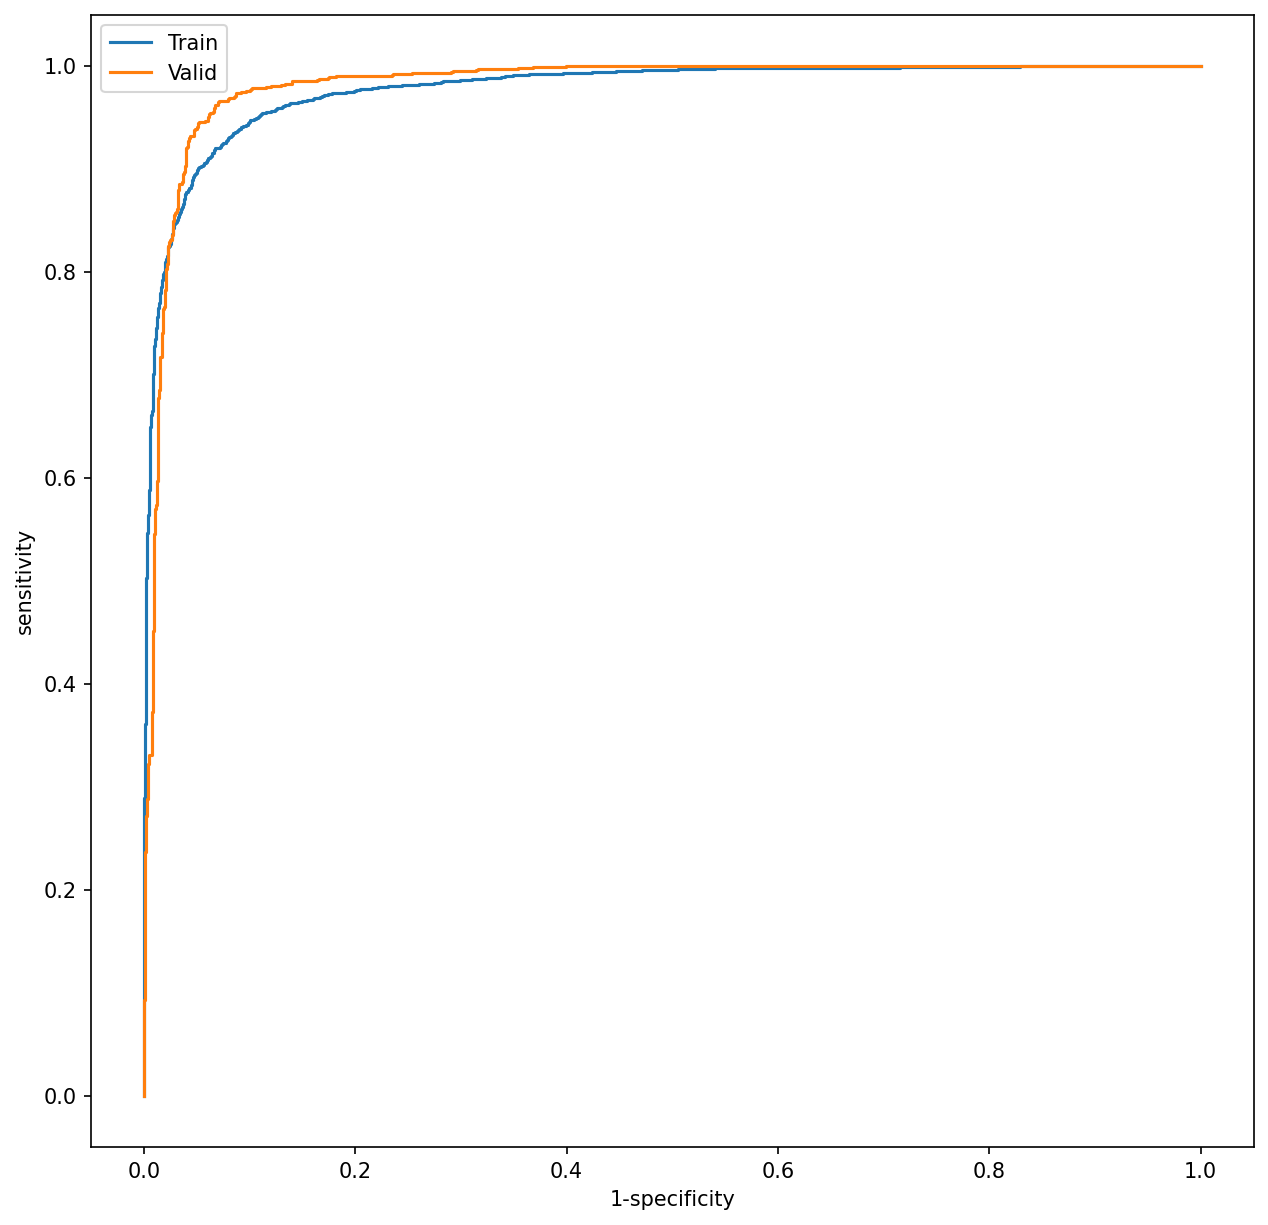

efficientnet-phospho-B-15
Fold: 2
Training on  4 GPUs!


  0%|          | 0/20 [00:00<?, ?it/s]

------------------------------------------------------------
Epoch 1/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.7069 Acc: 0.4981 Recall: 0.5897 AUC: 0.5041


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.6924 Acc: 0.5327 recall: 0.3140 AUC: 0.5364
------------------------------------------------------------

------------------------------------------------------------
Epoch 2/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.6655 Acc: 0.6006 Recall: 0.5460 AUC: 0.6385


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.6539 Acc: 0.6815 recall: 0.5168 AUC: 0.7493
------------------------------------------------------------

------------------------------------------------------------
Epoch 3/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.6151 Acc: 0.7084 Recall: 0.6415 AUC: 0.7811


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.5784 Acc: 0.8085 recall: 0.7574 AUC: 0.8863
------------------------------------------------------------

------------------------------------------------------------
Epoch 4/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.5474 Acc: 0.8085 Recall: 0.7480 AUC: 0.8851


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.4929 Acc: 0.8631 recall: 0.8108 AUC: 0.9403
------------------------------------------------------------

------------------------------------------------------------
Epoch 5/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.4634 Acc: 0.8618 Recall: 0.8198 AUC: 0.9380


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.4076 Acc: 0.8819 recall: 0.8054 AUC: 0.9629
------------------------------------------------------------

------------------------------------------------------------
Epoch 6/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.3765 Acc: 0.8962 Recall: 0.8656 AUC: 0.9624


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.3311 Acc: 0.8929 recall: 0.8145 AUC: 0.9769
------------------------------------------------------------

------------------------------------------------------------
Epoch 7/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.3000 Acc: 0.9191 Recall: 0.8931 AUC: 0.9761


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.2576 Acc: 0.9256 recall: 0.8795 AUC: 0.9846
------------------------------------------------------------

------------------------------------------------------------
Epoch 8/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.2428 Acc: 0.9364 Recall: 0.9186 AUC: 0.9837


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.2064 Acc: 0.9539 recall: 0.9347 AUC: 0.9892
------------------------------------------------------------

------------------------------------------------------------
Epoch 9/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.1978 Acc: 0.9486 Recall: 0.9368 AUC: 0.9884


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.1648 Acc: 0.9568 recall: 0.9309 AUC: 0.9923
------------------------------------------------------------

------------------------------------------------------------
Epoch 10/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.1625 Acc: 0.9579 Recall: 0.9451 AUC: 0.9920


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.1375 Acc: 0.9668 recall: 0.9533 AUC: 0.9941
------------------------------------------------------------

------------------------------------------------------------
Epoch 11/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.1415 Acc: 0.9613 Recall: 0.9493 AUC: 0.9932


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.1172 Acc: 0.9712 recall: 0.9597 AUC: 0.9954
------------------------------------------------------------

------------------------------------------------------------
Epoch 12/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.1236 Acc: 0.9655 Recall: 0.9551 AUC: 0.9945


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0988 Acc: 0.9742 recall: 0.9650 AUC: 0.9962
------------------------------------------------------------

------------------------------------------------------------
Epoch 13/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.1033 Acc: 0.9729 Recall: 0.9656 AUC: 0.9962


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0891 Acc: 0.9732 recall: 0.9590 AUC: 0.9969
------------------------------------------------------------

------------------------------------------------------------
Epoch 14/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.0937 Acc: 0.9749 Recall: 0.9684 AUC: 0.9967


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0817 Acc: 0.9762 recall: 0.9662 AUC: 0.9974
------------------------------------------------------------

------------------------------------------------------------
Epoch 15/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.0831 Acc: 0.9794 Recall: 0.9723 AUC: 0.9973


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0698 Acc: 0.9812 recall: 0.9759 AUC: 0.9977
------------------------------------------------------------

------------------------------------------------------------
Epoch 16/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.0757 Acc: 0.9786 Recall: 0.9718 AUC: 0.9979


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0656 Acc: 0.9802 recall: 0.9700 AUC: 0.9980
------------------------------------------------------------

------------------------------------------------------------
Epoch 17/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.0672 Acc: 0.9821 Recall: 0.9748 AUC: 0.9982


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0596 Acc: 0.9826 recall: 0.9729 AUC: 0.9982
------------------------------------------------------------

------------------------------------------------------------
Epoch 18/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.0613 Acc: 0.9840 Recall: 0.9778 AUC: 0.9986


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0538 Acc: 0.9851 recall: 0.9777 AUC: 0.9984
------------------------------------------------------------

------------------------------------------------------------
Epoch 19/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.0578 Acc: 0.9840 Recall: 0.9783 AUC: 0.9984


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0507 Acc: 0.9861 recall: 0.9795 AUC: 0.9986
------------------------------------------------------------

------------------------------------------------------------
Epoch 20/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.0532 Acc: 0.9854 Recall: 0.9791 AUC: 0.9988


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0516 Acc: 0.9821 recall: 0.9686 AUC: 0.9987
------------------------------------------------------------

Training complete in 1m 4s
Best val Loss: 0.050696
Best val Acc: 0.986111


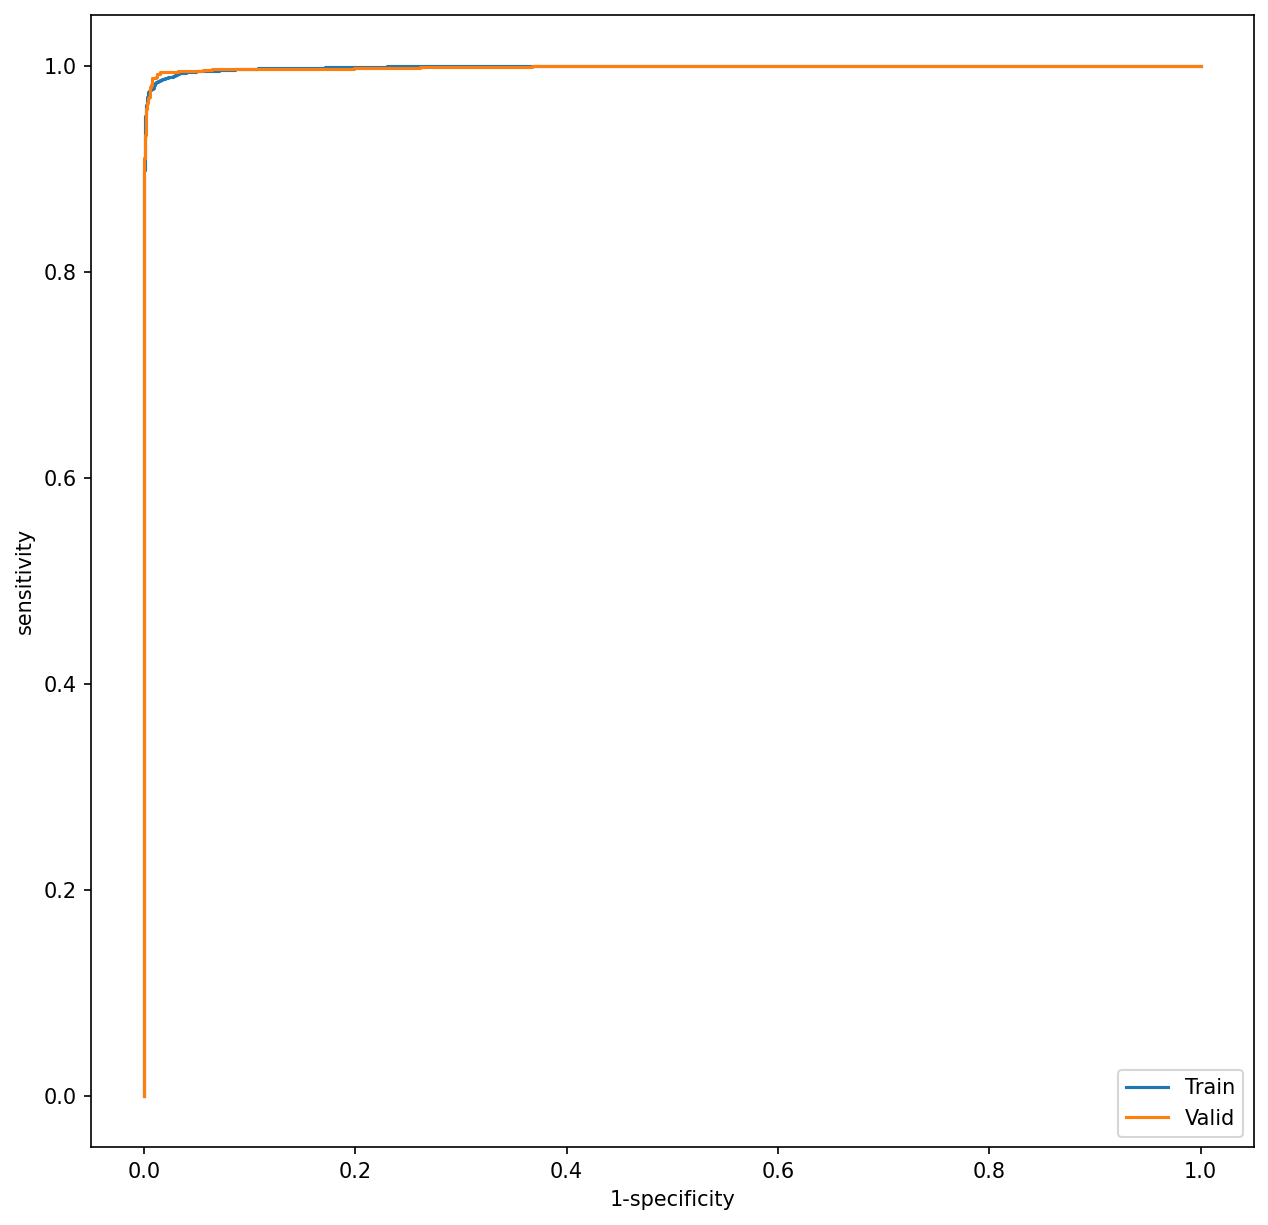

efficientnet-phospho-B-15
Fold: 3
Training on  4 GPUs!


  0%|          | 0/20 [00:00<?, ?it/s]

------------------------------------------------------------
Epoch 1/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.7061 Acc: 0.4910 Recall: 0.5105 AUC: 0.4943


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.6885 Acc: 0.5823 recall: 0.3565 AUC: 0.5868
------------------------------------------------------------

------------------------------------------------------------
Epoch 2/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.6692 Acc: 0.5904 Recall: 0.5492 AUC: 0.6271


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.6484 Acc: 0.6662 recall: 0.5144 AUC: 0.7310
------------------------------------------------------------

------------------------------------------------------------
Epoch 3/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.6262 Acc: 0.6804 Recall: 0.6533 AUC: 0.7452


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.5897 Acc: 0.7594 recall: 0.6264 AUC: 0.8445
------------------------------------------------------------

------------------------------------------------------------
Epoch 4/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.5728 Acc: 0.7564 Recall: 0.7257 AUC: 0.8385


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.5286 Acc: 0.8214 recall: 0.7894 AUC: 0.9038
------------------------------------------------------------

------------------------------------------------------------
Epoch 5/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.5028 Acc: 0.8194 Recall: 0.7957 AUC: 0.9015


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.4590 Acc: 0.8740 recall: 0.8545 AUC: 0.9446
------------------------------------------------------------

------------------------------------------------------------
Epoch 6/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.4274 Acc: 0.8726 Recall: 0.8528 AUC: 0.9417


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.3815 Acc: 0.9058 recall: 0.8712 AUC: 0.9669
------------------------------------------------------------

------------------------------------------------------------
Epoch 7/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.3533 Acc: 0.8992 Recall: 0.8776 AUC: 0.9644


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.3083 Acc: 0.9281 recall: 0.8867 AUC: 0.9796
------------------------------------------------------------

------------------------------------------------------------
Epoch 8/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.2865 Acc: 0.9261 Recall: 0.9048 AUC: 0.9789


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.2401 Acc: 0.9514 recall: 0.9245 AUC: 0.9880
------------------------------------------------------------

------------------------------------------------------------
Epoch 9/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.2292 Acc: 0.9431 Recall: 0.9219 AUC: 0.9884


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.1915 Acc: 0.9633 recall: 0.9413 AUC: 0.9928
------------------------------------------------------------

------------------------------------------------------------
Epoch 10/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.1824 Acc: 0.9575 Recall: 0.9424 AUC: 0.9932


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.1553 Acc: 0.9658 recall: 0.9435 AUC: 0.9954
------------------------------------------------------------

------------------------------------------------------------
Epoch 11/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.1499 Acc: 0.9667 Recall: 0.9507 AUC: 0.9957


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.1262 Acc: 0.9767 recall: 0.9649 AUC: 0.9971
------------------------------------------------------------

------------------------------------------------------------
Epoch 12/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.1251 Acc: 0.9738 Recall: 0.9622 AUC: 0.9972


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.1001 Acc: 0.9816 recall: 0.9740 AUC: 0.9982
------------------------------------------------------------

------------------------------------------------------------
Epoch 13/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.1058 Acc: 0.9789 Recall: 0.9683 AUC: 0.9981


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0844 Acc: 0.9826 recall: 0.9736 AUC: 0.9987
------------------------------------------------------------

------------------------------------------------------------
Epoch 14/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.0861 Acc: 0.9838 Recall: 0.9749 AUC: 0.9990


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0744 Acc: 0.9861 recall: 0.9795 AUC: 0.9990
------------------------------------------------------------

------------------------------------------------------------
Epoch 15/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.0765 Acc: 0.9859 Recall: 0.9782 AUC: 0.9990


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0625 Acc: 0.9866 recall: 0.9806 AUC: 0.9993
------------------------------------------------------------

------------------------------------------------------------
Epoch 16/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.0659 Acc: 0.9869 Recall: 0.9779 AUC: 0.9993


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0598 Acc: 0.9876 recall: 0.9764 AUC: 0.9994
------------------------------------------------------------

------------------------------------------------------------
Epoch 17/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.0563 Acc: 0.9891 Recall: 0.9816 AUC: 0.9994


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0494 Acc: 0.9886 recall: 0.9809 AUC: 0.9995
------------------------------------------------------------

------------------------------------------------------------
Epoch 18/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.0495 Acc: 0.9916 Recall: 0.9857 AUC: 0.9997


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0440 Acc: 0.9881 recall: 0.9797 AUC: 0.9995
------------------------------------------------------------

------------------------------------------------------------
Epoch 19/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.0435 Acc: 0.9925 Recall: 0.9858 AUC: 0.9998


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0405 Acc: 0.9896 recall: 0.9817 AUC: 0.9996
------------------------------------------------------------

------------------------------------------------------------
Epoch 20/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.0379 Acc: 0.9934 Recall: 0.9884 AUC: 0.9998


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0379 Acc: 0.9906 recall: 0.9841 AUC: 0.9996
------------------------------------------------------------

Training complete in 1m 3s
Best val Loss: 0.037854
Best val Acc: 0.990575


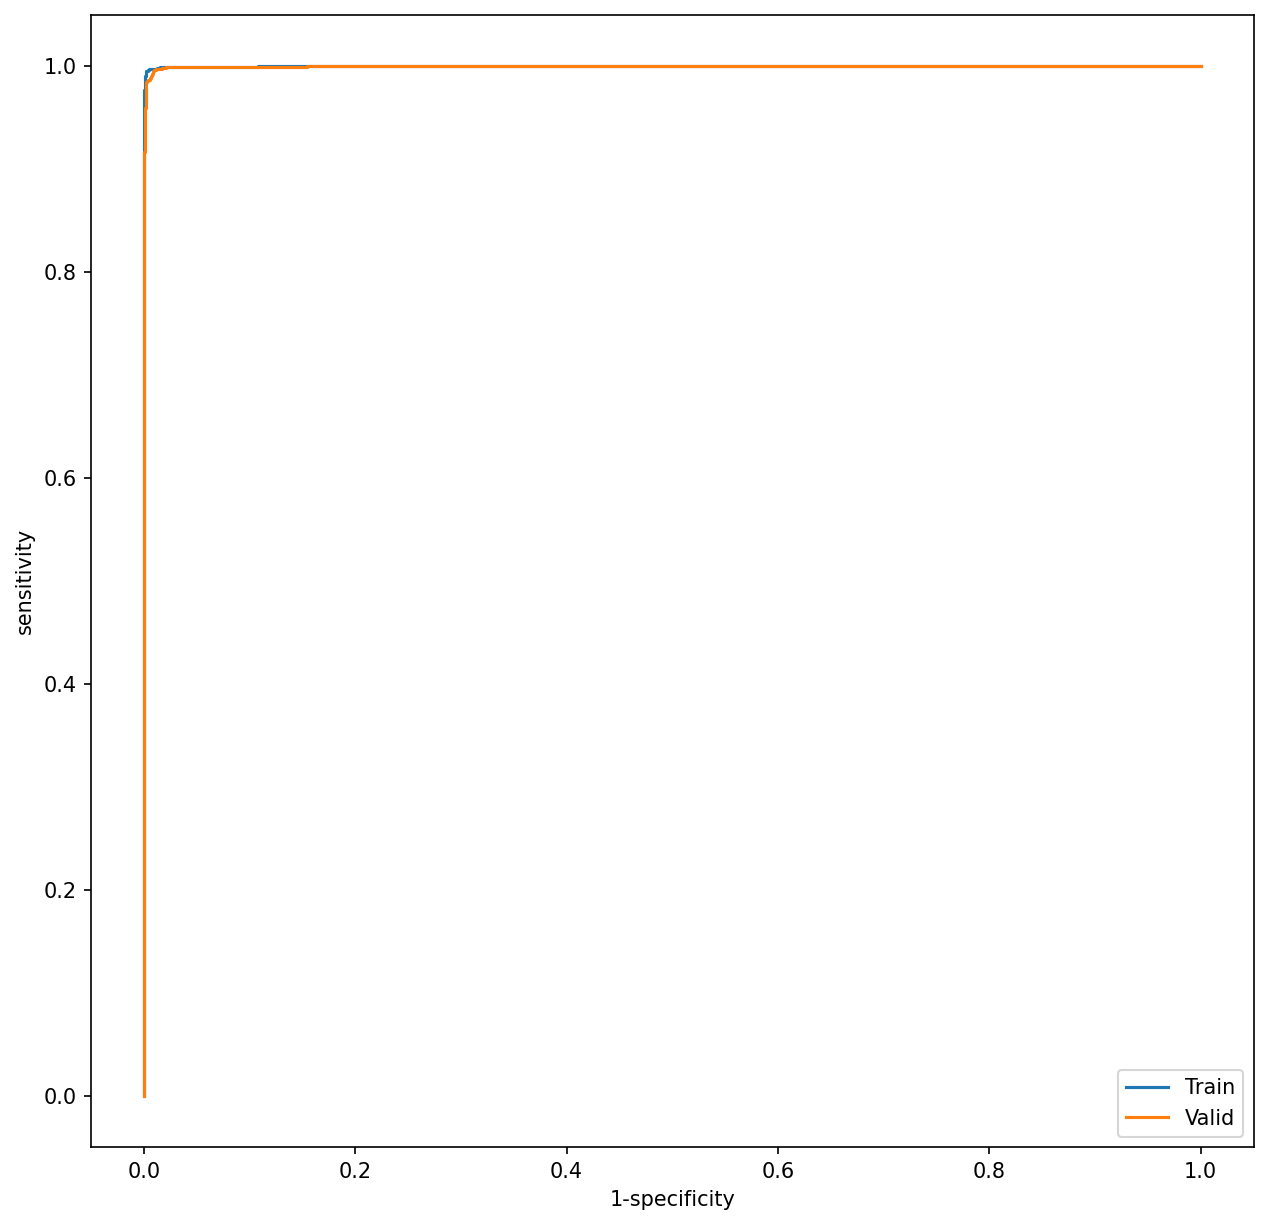

efficientnet-phospho-B-15
Fold: 4
Training on  4 GPUs!


  0%|          | 0/20 [00:00<?, ?it/s]

------------------------------------------------------------
Epoch 1/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.6995 Acc: 0.5218 Recall: 0.4975 AUC: 0.5307


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.6910 Acc: 0.5268 recall: 0.0466 AUC: 0.5735
------------------------------------------------------------

------------------------------------------------------------
Epoch 2/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.6676 Acc: 0.5933 Recall: 0.6084 AUC: 0.6287


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.6576 Acc: 0.6146 recall: 0.2882 AUC: 0.7208
------------------------------------------------------------

------------------------------------------------------------
Epoch 3/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.6268 Acc: 0.6781 Recall: 0.6517 AUC: 0.7357


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.6082 Acc: 0.7202 recall: 0.5488 AUC: 0.8112
------------------------------------------------------------

------------------------------------------------------------
Epoch 4/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.5868 Acc: 0.7299 Recall: 0.6841 AUC: 0.8021


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.5673 Acc: 0.7629 recall: 0.6224 AUC: 0.8605
------------------------------------------------------------

------------------------------------------------------------
Epoch 5/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.5420 Acc: 0.7730 Recall: 0.7331 AUC: 0.8521


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.5317 Acc: 0.7753 recall: 0.6115 AUC: 0.8902
------------------------------------------------------------

------------------------------------------------------------
Epoch 6/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.4971 Acc: 0.8035 Recall: 0.7625 AUC: 0.8848


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.4926 Acc: 0.8056 recall: 0.6708 AUC: 0.9103
------------------------------------------------------------

------------------------------------------------------------
Epoch 7/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.4481 Acc: 0.8394 Recall: 0.8119 AUC: 0.9140


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.4613 Acc: 0.7922 recall: 0.6289 AUC: 0.9280
------------------------------------------------------------

------------------------------------------------------------
Epoch 8/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.4020 Acc: 0.8629 Recall: 0.8263 AUC: 0.9348


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.4037 Acc: 0.8631 recall: 0.7760 AUC: 0.9414
------------------------------------------------------------

------------------------------------------------------------
Epoch 9/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.3567 Acc: 0.8851 Recall: 0.8667 AUC: 0.9496


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.3615 Acc: 0.8750 recall: 0.7928 AUC: 0.9533
------------------------------------------------------------

------------------------------------------------------------
Epoch 10/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.3108 Acc: 0.9081 Recall: 0.8897 AUC: 0.9648


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.3263 Acc: 0.8849 recall: 0.8123 AUC: 0.9617
------------------------------------------------------------

------------------------------------------------------------
Epoch 11/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.2699 Acc: 0.9215 Recall: 0.9054 AUC: 0.9743


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.2786 Acc: 0.9097 recall: 0.8627 AUC: 0.9695
------------------------------------------------------------

------------------------------------------------------------
Epoch 12/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.2367 Acc: 0.9311 Recall: 0.9160 AUC: 0.9802


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.2447 Acc: 0.9107 recall: 0.8630 AUC: 0.9765
------------------------------------------------------------

------------------------------------------------------------
Epoch 13/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.2037 Acc: 0.9443 Recall: 0.9333 AUC: 0.9858


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.2233 Acc: 0.9196 recall: 0.8721 AUC: 0.9811
------------------------------------------------------------

------------------------------------------------------------
Epoch 14/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.1776 Acc: 0.9525 Recall: 0.9432 AUC: 0.9895


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.1858 Acc: 0.9330 recall: 0.8950 AUC: 0.9857
------------------------------------------------------------

------------------------------------------------------------
Epoch 15/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.1588 Acc: 0.9566 Recall: 0.9481 AUC: 0.9915


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.1594 Acc: 0.9534 recall: 0.9355 AUC: 0.9890
------------------------------------------------------------

------------------------------------------------------------
Epoch 16/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.1375 Acc: 0.9635 Recall: 0.9562 AUC: 0.9937


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.1412 Acc: 0.9544 recall: 0.9361 AUC: 0.9915
------------------------------------------------------------

------------------------------------------------------------
Epoch 17/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.1209 Acc: 0.9699 Recall: 0.9628 AUC: 0.9953


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.1218 Acc: 0.9618 recall: 0.9456 AUC: 0.9934
------------------------------------------------------------

------------------------------------------------------------
Epoch 18/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.1100 Acc: 0.9730 Recall: 0.9646 AUC: 0.9959


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.1094 Acc: 0.9688 recall: 0.9545 AUC: 0.9949
------------------------------------------------------------

------------------------------------------------------------
Epoch 19/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.0987 Acc: 0.9748 Recall: 0.9688 AUC: 0.9969


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0969 Acc: 0.9722 recall: 0.9609 AUC: 0.9959
------------------------------------------------------------

------------------------------------------------------------
Epoch 20/20


  0%|          | 0/250 [00:00<?, ?it/s]

train Loss: 0.0895 Acc: 0.9770 Recall: 0.9698 AUC: 0.9975


  0%|          | 0/63 [00:00<?, ?it/s]

validation Loss: 0.0885 Acc: 0.9752 recall: 0.9652 AUC: 0.9968
------------------------------------------------------------

Training complete in 1m 4s
Best val Loss: 0.088504
Best val Acc: 0.975198


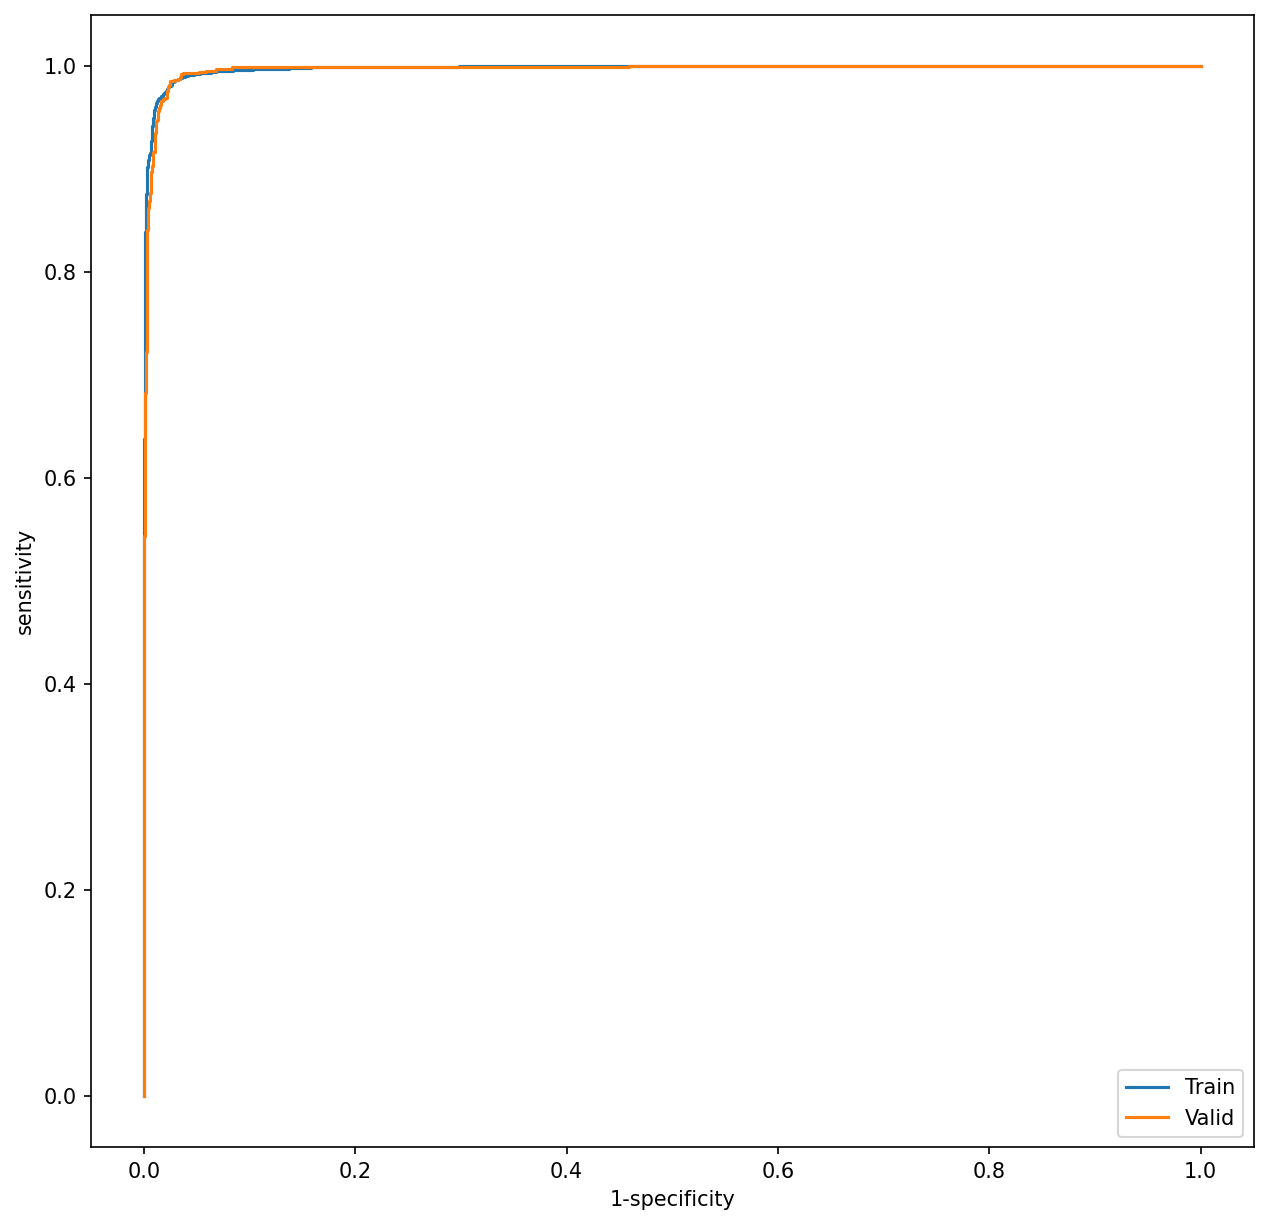

efficientnet-phospho-B-15
Kfold_cv_mean: 0.973413


In [59]:
best_acc_sum = 0
for fold, (tr_idx, val_idx) in enumerate(kf2.split(dfr2)):
    
    print('Fold: {:d}'.format(fold))
    BATCH_SIZE = 32

    train_set = data_utils.TensorDataset(torch.tensor(dfr2[tr_idx]), torch.tensor(dfl2[tr_idx]))
    valid_set = data_utils.TensorDataset(torch.tensor(dfr2[val_idx]),torch.tensor(dfl2[val_idx]))


    train_loader = data_utils.DataLoader(train_set, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
    valid_loader = data_utils.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)


    dataloaders = {'train':train_loader,'valid':valid_loader}
    dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'valid']}
    
    model = train_model(model, optimizer, scheduler, 20)
    
    plt.figure(figsize=[10,10],dpi = 150)
    plt.plot(Trainfprs, Traintprs, label= 'Train')
    plt.plot(Validfprs, Validtprs, label= 'Valid')
    #plt.plot(TrainLossdata, label= 'Train', color='lightcoral', linewidth = 4)
    plt.xlabel("1-specificity",fontsize =10)
    plt.ylabel("sensitivity",fontsize =10)
    plt.legend(fontsize = 10)
    plt.xlim()
    plt.ylim()
    plt.show()
    best_acc_sum += best_acc
    del model
    allele = 'phospho-B-15'
    model = EfficientNet.from_name(f'efficientnet-{allele}')
    criterion = nn.BCELoss()
    optimizer = RAdam(model.parameters())
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    
    save_dir = f'saved_model_samp10000_samp32/Efficientnet_fold_{fold+1}_kernel_3_ms_only_same_ratio'
    writer = SummaryWriter(save_dir)
    
    if fold == 4:
        print('Kfold_cv_mean: {:2f}'.format(best_acc_sum/(fold+1)))

In [ ]:
#batch = 32 #mse계산용
best_acc_sum = 0
for fold, (tr_idx, val_idx) in enumerate(kf2.split(dfr2)):
    
    print('Fold: {:d}'.format(fold))
    BATCH_SIZE = 32

    train_set = data_utils.TensorDataset(torch.tensor(dfr2[tr_idx]), torch.tensor(dfl2[tr_idx]))
    valid_set = data_utils.TensorDataset(torch.tensor(dfr2[val_idx]),torch.tensor(dfl2[val_idx]))


    train_loader = data_utils.DataLoader(train_set, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
    valid_loader = data_utils.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)


    dataloaders = {'train':train_loader,'valid':valid_loader}
    dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'valid']}
    
    model = train_model(model, optimizer, scheduler, 20)
    
    plt.figure(figsize=[30,30],dpi = 600)
    #plt.plot(Trainfprs, Traintprs, label= 'Train')
    plt.plot(TrainLossdata, label= 'Train', color='lightcoral', linewidth = 4)
    plt.xlabel("epoch",fontsize =40)
    plt.ylabel("MSE",fontsize =40)
    plt.legend(fontsize = 40)
    plt.xlim()
    plt.ylim()
    plt.savefig("High resoltion.png",dpi=600)
    plt.show()
    best_acc_sum += best_acc
    del model
    allele = 'phospho-B-15'
    model = EfficientNet.from_name(f'efficientnet-{allele}')
    criterion = nn.MSELoss()
    optimizer = RAdam(model.parameters())
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    
    save_dir = f'saved_model2/Efficientnet_{fold+1}_kernel_3_ms_only_same_ratio'
    writer = SummaryWriter(save_dir)
    
    if fold == 4:
        print('Kfold_cv_mean: {:2f}'.format(best_acc_sum/(fold+1)))

In [60]:
#batch_size=128인경우
save_dir = f'saved_modeltemp_batch_size128/Efficientnet_0_kernel_3_ms_only_same_ratio'
writer = SummaryWriter(save_dir)

In [ ]:
best_acc_sum = 0
for fold, (tr_idx, val_idx) in enumerate(kf2.split(dfr2)):
    
    print('Fold: {:d}'.format(fold))
    BATCH_SIZE = 128

    train_set = data_utils.TensorDataset(torch.tensor(dfr2[tr_idx]), torch.tensor(dfl2[tr_idx]))
    valid_set = data_utils.TensorDataset(torch.tensor(dfr2[val_idx]),torch.tensor(dfl2[val_idx]))


    train_loader = data_utils.DataLoader(train_set, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
    valid_loader = data_utils.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)


    dataloaders = {'train':train_loader,'valid':valid_loader}
    dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'valid']}
    
    model = train_model(model, optimizer, scheduler, 20)
    
    plt.figure(dpi = 150)
    plt.plot([0,1],[0,1])
    plt.plot(Trainfprs, Traintprs, label= 'Train')
    plt.plot(Validfprs, Validtprs, label= 'Valid')
    plt.legend()
    plt.xlabel("1-specificity",fontsize =10)
    plt.ylabel("sensitivity",fontsize =10)
    plt.legend(fontsize = 10)
    plt.xlim()
    plt.ylim()
    plt.show()
    best_acc_sum += best_acc
    del model
    allele = 'phospho-B-15'
    model = EfficientNet.from_name(f'efficientnet-{allele}')
    criterion = nn.BCELoss()
    optimizer = RAdam(model.parameters())
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    
    save_dir = f'saved_modeltemp_batch_size128/Efficientnet_{fold+1}_kernel_3_ms_only_same_ratio'
    writer = SummaryWriter(save_dir)
    
    if fold == 4:
        print('Kfold_cv_mean: {:2f}'.format(best_acc_sum/(fold+1)))

In [ ]:
#batch = 128 #mse계산용
best_acc_sum = 0
for fold, (tr_idx, val_idx) in enumerate(kf2.split(dfr2)):
    
    print('Fold: {:d}'.format(fold))
    BATCH_SIZE = 128

    train_set = data_utils.TensorDataset(torch.tensor(dfr2[tr_idx]), torch.tensor(dfl2[tr_idx]))
    valid_set = data_utils.TensorDataset(torch.tensor(dfr2[val_idx]),torch.tensor(dfl2[val_idx]))


    train_loader = data_utils.DataLoader(train_set, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
    valid_loader = data_utils.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)


    dataloaders = {'train':train_loader,'valid':valid_loader}
    dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'valid']}
    
    model = train_model(model, optimizer, scheduler, 20)
    
    plt.figure(figsize=[30,30],dpi = 600)
    #plt.plot(Trainfprs, Traintprs, label= 'Train')
    plt.plot(TrainLossdata, label= 'Train', color='lightcoral', linewidth = 4)
    plt.xlabel("epoch",fontsize =40)
    plt.ylabel("MSE",fontsize =40)
    plt.legend(fontsize = 40)
    plt.xlim()
    plt.ylim()
    plt.savefig("High resoltion.png",dpi=600)
    plt.show()
    best_acc_sum += best_acc
    del model
    allele = 'phospho-B-15'
    model = EfficientNet.from_name(f'efficientnet-{allele}')
    criterion = nn.MSELoss()
    optimizer = RAdam(model.parameters())
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    
    save_dir = f'saved_model2/Efficientnet_{fold+1}_kernel_3_ms_only_same_ratio'
    writer = SummaryWriter(save_dir)
    
    if fold == 4:
        print('Kfold_cv_mean: {:2f}'.format(best_acc_sum/(fold+1)))

In [ ]:
#batch_size=256인경우
save_dir = f'saved_modeltemp/Efficientnet_0_kernel_3_ms_only_same_ratio'
writer = SummaryWriter(save_dir)

In [ ]:
best_acc_sum = 0
for fold, (tr_idx, val_idx) in enumerate(kf2.split(dfr2)):
    
    print('Fold: {:d}'.format(fold))
    BATCH_SIZE = 256

    train_set = data_utils.TensorDataset(torch.tensor(dfr2[tr_idx]), torch.tensor(dfl2[tr_idx]))
    valid_set = data_utils.TensorDataset(torch.tensor(dfr2[val_idx]),torch.tensor(dfl2[val_idx]))


    train_loader = data_utils.DataLoader(train_set, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
    valid_loader = data_utils.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)


    dataloaders = {'train':train_loader,'valid':valid_loader}
    dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'valid']}
    
    model = train_model(model, optimizer, scheduler, 20)
    
    plt.figure(dpi = 150)
    plt.plot([0,1],[0,1])
    plt.plot(Trainfprs, Traintprs, label= 'Train')
    plt.plot(Validfprs, Validtprs, label= 'Valid')
    plt.legend()
    plt.xlabel("1-specificity",fontsize =10)
    plt.ylabel("sensitivity",fontsize =10)
    plt.xlim()
    plt.ylim()
    plt.show()
    best_acc_sum += best_acc
    
    del model
    allele = 'phospho-B-15'
    model = EfficientNet.from_name(f'efficientnet-{allele}')
    criterion = nn.BCELoss()
    optimizer = RAdam(model.parameters())
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    
    save_dir = f'saved_modeltemp/Efficientnet_{fold+1}_kernel_3_ms_only_same_ratio'
    writer = SummaryWriter(save_dir)
    
    if fold == 4:
        print('Kfold_cv_mean: {:2f}'.format(best_acc_sum/(fold+1)))

In [ ]:
#batch = 256 #mse계산용
best_acc_sum = 0
for fold, (tr_idx, val_idx) in enumerate(kf2.split(dfr2)):
    
    print('Fold: {:d}'.format(fold))
    BATCH_SIZE = 256

    train_set = data_utils.TensorDataset(torch.tensor(dfr2[tr_idx]), torch.tensor(dfl2[tr_idx]))
    valid_set = data_utils.TensorDataset(torch.tensor(dfr2[val_idx]),torch.tensor(dfl2[val_idx]))


    train_loader = data_utils.DataLoader(train_set, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
    valid_loader = data_utils.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)


    dataloaders = {'train':train_loader,'valid':valid_loader}
    dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'valid']}
    
    model = train_model(model, optimizer, scheduler, 20)
    
    plt.figure(figsize=[10,10],dpi = 600)
    #plt.plot(Trainfprs, Traintprs, label= 'Train')
    plt.plot(TrainLossdata, label= 'Train', color='lightcoral', linewidth = 6)
    #plt.plot([1,0],[1,0],"--")
    plt.xlabel("epoch",fontsize =20)
    plt.ylabel("MSE",fontsize =20)
    plt.rc('xtick', labelsize=15)  
    plt.rc('ytick', labelsize=15) 
    plt.legend(fontsize = 20)
    plt.xlim()
    plt.ylim()
    plt.savefig("High resoltion.png",dpi=600)
    plt.show()
    best_acc_sum += best_acc
    del model
    allele = 'phospho-B-15'
    model = EfficientNet.from_name(f'efficientnet-{allele}')
    criterion = nn.MSELoss()
    optimizer = RAdam(model.parameters())
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    
    save_dir = f'saved_model2/Efficientnet_{fold+1}_kernel_3_ms_only_same_ratio'
    writer = SummaryWriter(save_dir)
    
    if fold == 4:
        print('Kfold_cv_mean: {:2f}'.format(best_acc_sum/(fold+1)))

In [ ]:
#batch_size=16인경우
save_dir = f'saved_model5/Efficientnet_0_kernel_3_ms_only_same_ratio'
writer = SummaryWriter(save_dir)

In [ ]:
best_acc_sum = 0
for fold, (tr_idx, val_idx) in enumerate(kf2.split(dfr2)):
    
    print('Fold: {:d}'.format(fold))
    BATCH_SIZE = 16

    train_set = data_utils.TensorDataset(torch.tensor(dfr2[tr_idx]), torch.tensor(dfl2[tr_idx]))
    valid_set = data_utils.TensorDataset(torch.tensor(dfr2[val_idx]),torch.tensor(dfl2[val_idx]))


    train_loader = data_utils.DataLoader(train_set, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
    valid_loader = data_utils.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)


    dataloaders = {'train':train_loader,'valid':valid_loader}
    dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'valid']}
    
    model = train_model(model, optimizer, scheduler, 20)
    
    plt.figure(dpi = 150)
    plt.plot(Trainfprs, Traintprs, label= 'Train')
    plt.plot(Validfprs, Validtprs, label= 'Valid')
    #plt.plot(TrainLossdata, label= 'Train', color='lightcoral', linewidth = 4)
    plt.xlabel("1-specificity",fontsize =10)
    plt.ylabel("sensitivity",fontsize =10)
    plt.legend(fontsize = 10)
    plt.xlim()
    plt.ylim()
    plt.show()
    best_acc_sum += best_acc
    del model
    allele = 'phospho-B-15'
    model = EfficientNet.from_name(f'efficientnet-{allele}')
    criterion = nn.BCELoss()
    optimizer = RAdam(model.parameters())
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    
    save_dir = f'saved_model5/Efficientnet_{fold+1}_kernel_3_ms_only_same_ratio'
    writer = SummaryWriter(save_dir)
    
    if fold == 4:
        print('Kfold_cv_mean: {:2f}'.format(best_acc_sum/(fold+1)))

In [ ]:
results = results[:5000]

In [ ]:
results = []

for out in outputs:
    results.append(int(out.cpu().detach()))

In [ ]:
dfl2[tr_idx]

In [ ]:
np.bincount(dfl2[tr_idx])

In [ ]:
#위가 마지막 train작업 이제 test돌리면 됨

In [ ]:
allele = 'phospho-B-15'
model = EfficientNet.from_name(f'efficientnet-{allele}')
model = nn.DataParallel(model)
model.load_state_dict(torch.load('/home/geonwon/Code'
                                 '/saved_model2'
                                 '/Efficientnet_1_kernel_3_ms_only_same_ratio/best_16.pth')['state_dict'])
model.eval()

In [ ]:
criterion = nn.BCELoss()
optimizer = RAdam(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

#Writer will output to ./runs/ directory by default
save_dir = f'saved_test_model/Efficientnet_{allele}_kernel_3_ms_only_same_ratio'
writer = SummaryWriter(save_dir)

In [ ]:
def test_model(model, optimizer, scheduler, num_epochs=200):
    
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    since = time.time()

    #best_model_wts = model.state_dict()
    model.load_state_dict(torch.load('/home/geonwon/Code'
                                 '/saved_model_EfficientNet_training(Train21266+Val7089+Test7089)preproesssing3'
                                 '/Efficientnet_phospho-B-15_kernel_3_ms_only_same_ratio/best_49.pth')['state_dict'])
    best_loss = 1000.0
    
    if torch.cuda.device_count() > 1:
        print("Testing on ", torch.cuda.device_count(), "GPUs!")
        #model = nn.DataParallel(model)

    model.to(device)
    #criterion.to(device)
    #model.eval()
    
    for epoch in tqdm(range(num_epochs)):
        print('-' * 60)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))  
        
        # Test step
        test_loss = 0.0
        test_corrects = 0.0
        test_precision, test_recall, test_f1 = 0.0, 0.0, 0.0
        
        for data in tqdm(dataloaders['test']):
             # get the inputs
            inputs, labels = data
            inputs = Variable(inputs.to(device, dtype=torch.float))
            labels = Variable(labels.to(device))
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            preds = (outputs>=0.5).float()
            #_, preds = torch.max(outputs.data, 1)
            #loss = F.binary_cross_entropy(outputs, labels.float().view(-1,1)).to(device)
            #loss = F1_Loss(labels.float().view(-1,1).cpu(), outputs.cpu())
            precision, recall, f1 = precision_recall(labels.float().view(-1,1).cpu(), outputs.cpu())
            loss = criterion(outputs, labels.float().view(-1,1)).to(device)



            # statistics
            test_loss += loss.data
            test_precision += precision.data
            test_recall += recall.data
            test_f1 += f1.data
            test_corrects += accuracy_score(labels.cpu(), preds.cpu())

        epoch_test_loss = test_loss / dataset_sizes['test']
        epoch_test_precision = test_precision / dataset_sizes['test']
        epoch_test_recall = test_recall / dataset_sizes['test']
        epoch_test_f1 = test_f1 / dataset_sizes['test']
        epoch_test_acc = test_corrects / dataset_sizes['test']


        writer.add_scalars('Loss' , {'test':epoch_test_loss}, epoch)
        writer.add_scalars('Accuracy' , {'test':epoch_test_acc},  epoch)
        writer.add_scalars('F1' , {'test':epoch_test_f1},  epoch)
        writer.add_scalars('precision' , {'test':epoch_test_precision},  epoch)
        writer.add_scalars('recall' , {'test':epoch_test_recall},  epoch)



        print('{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f} recall: {:.4f}'.format(
            'test', epoch_test_loss, epoch_test_acc, epoch_test_f1,epoch_test_recall ))

        # deep copy the model
        if  epoch_test_loss < best_loss:
            best_loss = epoch_test_loss
            best_model_wts = model.state_dict()
            # save
            checkpoint = {'model': model,
                      #'state_dict': model.module.state_dict(),
                          'state_dict': model.state_dict(),
                      'optimizer' : optimizer.state_dict()}

            savePath = "{}/best_{}.pth".format(save_dir, epoch+1)
            torch.save(checkpoint, savePath)
        else:
            # save
            checkpoint = {'model': model,
                      #'state_dict': model.module.state_dict(),
                          'state_dict': model.state_dict(),
                      'optimizer' : optimizer.state_dict()}

            savePath = "{}/{}.pth".format(save_dir, epoch+1)
            torch.save(checkpoint, savePath)


        print('-' * 60)
        print()         

    time_elapsed = time.time() - since
    print('Test complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Loss: {:4f}'.format(best_loss))
    # load best model weights
    #model.load_state_dict(best_model_wts)
    return model

In [ ]:
BATCH_SIZE = 1

test_set = data_utils.TensorDataset(torch.tensor(xTest),torch.tensor(yTest))


test_loader = data_utils.DataLoader(test_set, batch_size=BATCH_SIZE,shuffle= False, pin_memory = True)


dataloaders = {'test':test_loader}
dataset_sizes = {x: len(dataloaders[x]) for x in ['test']}
#custom dataloaders로 불러올때마다 sampling 다르게해서 추출하기

In [ ]:
model = test_model(model, optimizer, scheduler, 10)

In [ ]:
summary(model, input_size=(1, 336, 15))

In [ ]:
roc_auc_score(ValidTruedata, ValidScoredata)